## Pairs Trading with 2 stocks/ETFs/Bonds/Commodities which run together

## A pair (douplet) is simply two assets that move together in the long run (cointegrated) but may diverge temporarily.
### The strategy bets that this divergence will revert : so you go long the undervalued and short the overvalued asset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## To check for the stationarity
from statsmodels.tsa.stattools import adfuller

## To check for the cointegration, using Johansen tests
from statsmodels.tsa.stattools import coint

## To calculate the hedge ratio
import statsmodels.api as sm

## To get the data
import yfinance as yf

## To visualize the graphs
import plotly.io as pio
pio.renderers.default = 'iframe' ## can use browser also

import plotly.express as px

## avoid warnings
import warnings
warnings.filterwarnings("ignore")

## Download daily ETFs data

In [2]:
def download_daily_data(ticker,start,end):
    """
    This function will help an individual to download the daily data from yahoo finance
    """

    data = yf.download(ticker,start,end,auto_adjust = False,interval = '1d')

    ## dropping the multiple index
    if isinstance(data.columns,pd.MultiIndex):
        data.columns = data.columns.droplevel(1)

    ## Removing the unwarranted columns, since for trading ETFs we only need the Adj Close price
    desired_columns = ["Adj Close"]
    ## Filtering and reordering columns into deriable sequence
    data = data[[col for col in desired_columns if col in data.columns]]
    # Remove the name of the column index (e.g., 'Price') for cleaner output.
    data.columns.name = None

    return data

### Downloading the Gold and Silver ETFs data

### Choosing the 2022 to 2025 timeframe as to capture the aftermath of covid and other fluctuatiuons in the metal market in India 

In [35]:
Gold = download_daily_data("GOLDBEES.NS","2022-02-04","2025-02-01")
Gold.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2022-02-04,41.599998
2022-02-07,41.630001
2022-02-08,41.820000
2022-02-09,41.990002
2022-02-10,42.169998


In [37]:
Silver = download_daily_data("SILVERBEES.NS","2021-03-01","2025-02-01")
Silver.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2022-02-04,60.959599
2022-02-07,61.770000
2022-02-08,62.279999
2022-02-09,62.770000
2022-02-10,62.799999


In [38]:
GLDSLV = pd.concat([Gold,Silver],axis = 1)
GLDSLV.columns = ["Gold","Silver"]
GLDSLV.head()

,Gold,Silver
Date,,
2022-02-04,41.599998,60.959599
2022-02-07,41.630001,61.770000
2022-02-08,41.820000,62.279999
2022-02-09,41.990002,62.770000
2022-02-10,42.169998,62.799999


## Calculating the percentage returns of both ETFS and then calculating the cumulative returns 

In [39]:
cumrets = (GLDSLV.pct_change() + 1).cumprod()


In [40]:
GLDSLV["GLD_returns"] = GLDSLV["Gold"].pct_change() 

In [41]:
GLDSLV["SLV_returns"] = GLDSLV["Silver"].pct_change()

In [42]:
fig = px.line(cumrets)
fig.show()

## Checking for correlation between the stock to find if they are moving in the same direction or not

In [43]:
corr_matrix = GLDSLV[["GLD_returns","SLV_returns"]].corr()

In [44]:
corr_matrix

,GLD_returns,SLV_returns
GLD_returns,1.000000,0.758899
SLV_returns,0.758899,1.000000


Since the correlation is above 0.75 it is pretty strong

In [16]:
type(GLDSLV.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [45]:
GLDSLV_sliced = GLDSLV.copy()

## Calculating the hedge ratio, to find how much should be ratio of buying and selling between the pair while trading

In [46]:
from statsmodels.api import OLS
## Taking last 120 days of data to reduce the look ahead bias
model = OLS(GLDSLV_sliced["Silver"],GLDSLV_sliced["Gold"])
model = model.fit()
print("The hedge ratio for the Gold and Silver is ")
model.params

The hedge ratio for the Gold and Silver is 


Gold    1.374251
dtype: float64

In [47]:
## Storing the hedge ratio in a variable 
m1 = model.params.iloc[0]
m1

1.3742505588772411

## Calculating the spread 

In [48]:
GLDSLV_sliced["spread"] = GLDSLV_sliced.Silver  - m1 *GLDSLV_sliced.Gold

In [50]:
print('The spread is: Silver - %f * Gold' %
      (model.params.iloc[0]))


The spread is: Silver - 1.374251 * Gold


In [51]:
# Plot the spread
fig = px.line(GLDSLV_sliced, y='spread')
fig.show()

## Running the ADF test 


In [52]:
## perform the ADF test
adf = adfuller(GLDSLV_sliced.spread,maxlag = 1)

## Compute ADF test statistics
print(f"The t- stats value is {adf[0]}")


The t- stats value is -3.4218858520442565


In [53]:
print(f"And the critical value is at 95% confidence {adf[4]['5%']}")

And the critical value is at 95% confidence -2.86546960465041


In [54]:
## Cheching for cointegration

critical_val = adf[4]['5%']
t_stat = adf[0]

## Comparison of values
cointegrated = t_stat < critical_val

## setting the result as true if cointegrated else False 
is_Gld_Slv_cointegrated  = True if cointegrated else False

f"The Gold and Silver are cointegrated {is_Gld_Slv_cointegrated}"

'The Gold and Silver are cointegrated True'

## Applying the mean reversion strategy on the spread

In [59]:
def arbitrage_trading(df,lookback,std_dev):
    df["moving_average"] = df.spread.rolling(lookback).mean()
    df["moving_std_dev"] = df.spread.rolling(lookback).std()

    ## Making the bollinger bands
    df["upper_band"] = df.moving_average + std_dev*df.moving_std_dev
    df["lower_band"] = df.moving_average - std_dev*df.moving_std_dev

    ## Long entry and exit
    df["long_entry"] = df.spread < df.lower_band
    df["long_exit"] = df.spread >= df.moving_average
    df["positions_long"] = np.nan
    df.loc[df.long_entry == True,"positions_long"] = 1
    df.loc[df.long_exit == True,"positions_long"] = 0
    df.positions_long = df.positions_long.ffill()

    df["short_entry"] = df.spread > df.upper_band
    df["short_exit"] = df.spread <= df.moving_average
    df["positions_short"] = np.nan
    df.loc[df.short_entry == True,"positions_short"] = -1
    df.loc[df.short_exit == True, "positions_short"] = 0
    df.positions_short = df.positions_short.ffill()

    df["positions"] = df.positions_short + df.positions_long

    df['percentage_change'] = (df.spread - df.spread.shift(1))/(model.params[0]*df.Gold + 1 * df.Silver)
    df['strategy_returns'] = df.positions.shift(1) * df.percentage_change
    df['cumulative_returns'] = (df.strategy_returns+1).cumprod()
    
    return df
     

In [85]:
## Passing the rolling window for moving avg and std_dev is 
GLDSLV_sliced = arbitrage_trading(GLDSLV_sliced,22,1.2)

In [87]:
GLDSLV_sliced.tail()

,Gold,Silver,GLD_returns,SLV_returns,spread,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,positions_long,short_entry,short_exit,positions_short,positions,percentage_change,strategy_returns,cumulative_returns
Date,,,,,,,,,,,,,,,,,,,
2025-01-27,67.690002,87.589996,-0.001180,-0.012180,-5.433027,-3.646583,0.923210,-2.538730,-4.754435,True,False,1.0,False,True,0.0,1.0,-0.005371,-0.005371,1.164478
2025-01-28,67.580002,87.099998,-0.001625,-0.005594,-5.771857,-3.793911,0.992653,-2.602727,-4.985095,True,False,1.0,False,True,0.0,1.0,-0.001883,-0.001883,1.162286
2025-01-29,67.860001,88.010002,0.004143,0.010448,-5.246642,-3.895939,1.022297,-2.669182,-5.122695,True,False,1.0,False,True,0.0,1.0,0.002897,0.002897,1.165653
2025-01-30,68.089996,89.500000,0.003389,0.016930,-4.072716,-3.883530,1.018227,-2.661658,-5.105402,False,False,1.0,False,True,0.0,1.0,0.006412,0.006412,1.173128
2025-01-31,69.080002,90.669998,0.014540,0.013073,-4.263233,-3.868994,1.010015,-2.656976,-5.081012,False,False,1.0,False,True,0.0,1.0,-0.001026,-0.001026,1.171924


## Calculating the strategy returns 

In [86]:
"The total strategy returns are %.2f" % ((GLDSLV_sliced['cumulative_returns'].iloc[-1]-1)*100)

'The total strategy returns are 17.19'

## Calculating the sharpe ratio

In [88]:
S = np.mean(GLDSLV_sliced["strategy_returns"])/ np.std(GLDSLV_sliced["strategy_returns"]) * (252 ** 0.5)
'The Sharpe Ratio %.2f is' % S

'The Sharpe Ratio 0.87 is'

## Plotting the Cumulative returns

In [89]:
fig = px.line(GLDSLV_sliced, y='cumulative_returns', color_discrete_sequence=['magenta'], template='plotly_white')
fig.show()

## Calculating the drawdown

In [90]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown


import plotly.graph_objects as go

def plot_drawdown(drawdown):
    
    # Create a Plotly figure
    fig = go.Figure()

    # Add the filled area under the curve
    fig.add_trace(go.Scatter(x=drawdown.index,y=drawdown, 
        mode='lines', 
        fill='tozeroy', 
        fillcolor='rgba(255, 0, 0, 0.3)',  # Semi-transparent red
        line=dict(color='red'), 
                                                                
    ))

    # Update the layout to include axis labels
    fig.update_layout(
        title='Drawdown Plot',
        xaxis_title='Date',  # Label for the x-axis
        yaxis_title='Drawdown',  # Label for the y-axis
        template='plotly_white'
    )    

    # Show the interactive plot
    fig.show()


drawdown = calc_drawdown(GLDSLV_sliced.cumulative_returns)
print("The maximum drawdown is %.2f" % (drawdown.min()*100))
plot_drawdown(drawdown)

The maximum drawdown is -6.42


Start date,2022-02-04
End date,2025-01-31
Total months,35
,Backtest
Annual return,5.559%
Cumulative returns,17.192%
Annual volatility,6.701%
Sharpe ratio,0.87
Calmar ratio,0.87
Stability,0.70
Max drawdown,-6.419%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.42,2022-11-03,2023-05-25,2023-09-04,218
1,5.85,2024-05-10,2024-05-29,2024-09-06,86
2,5.39,2022-04-26,2022-07-26,2022-11-03,138
3,2.32,2024-11-19,2024-11-28,2024-12-13,19
4,2.13,2024-01-02,2024-02-07,2024-04-03,67


Stress Events,mean,min,max
Covid,0.02%,-3.00%,1.60%


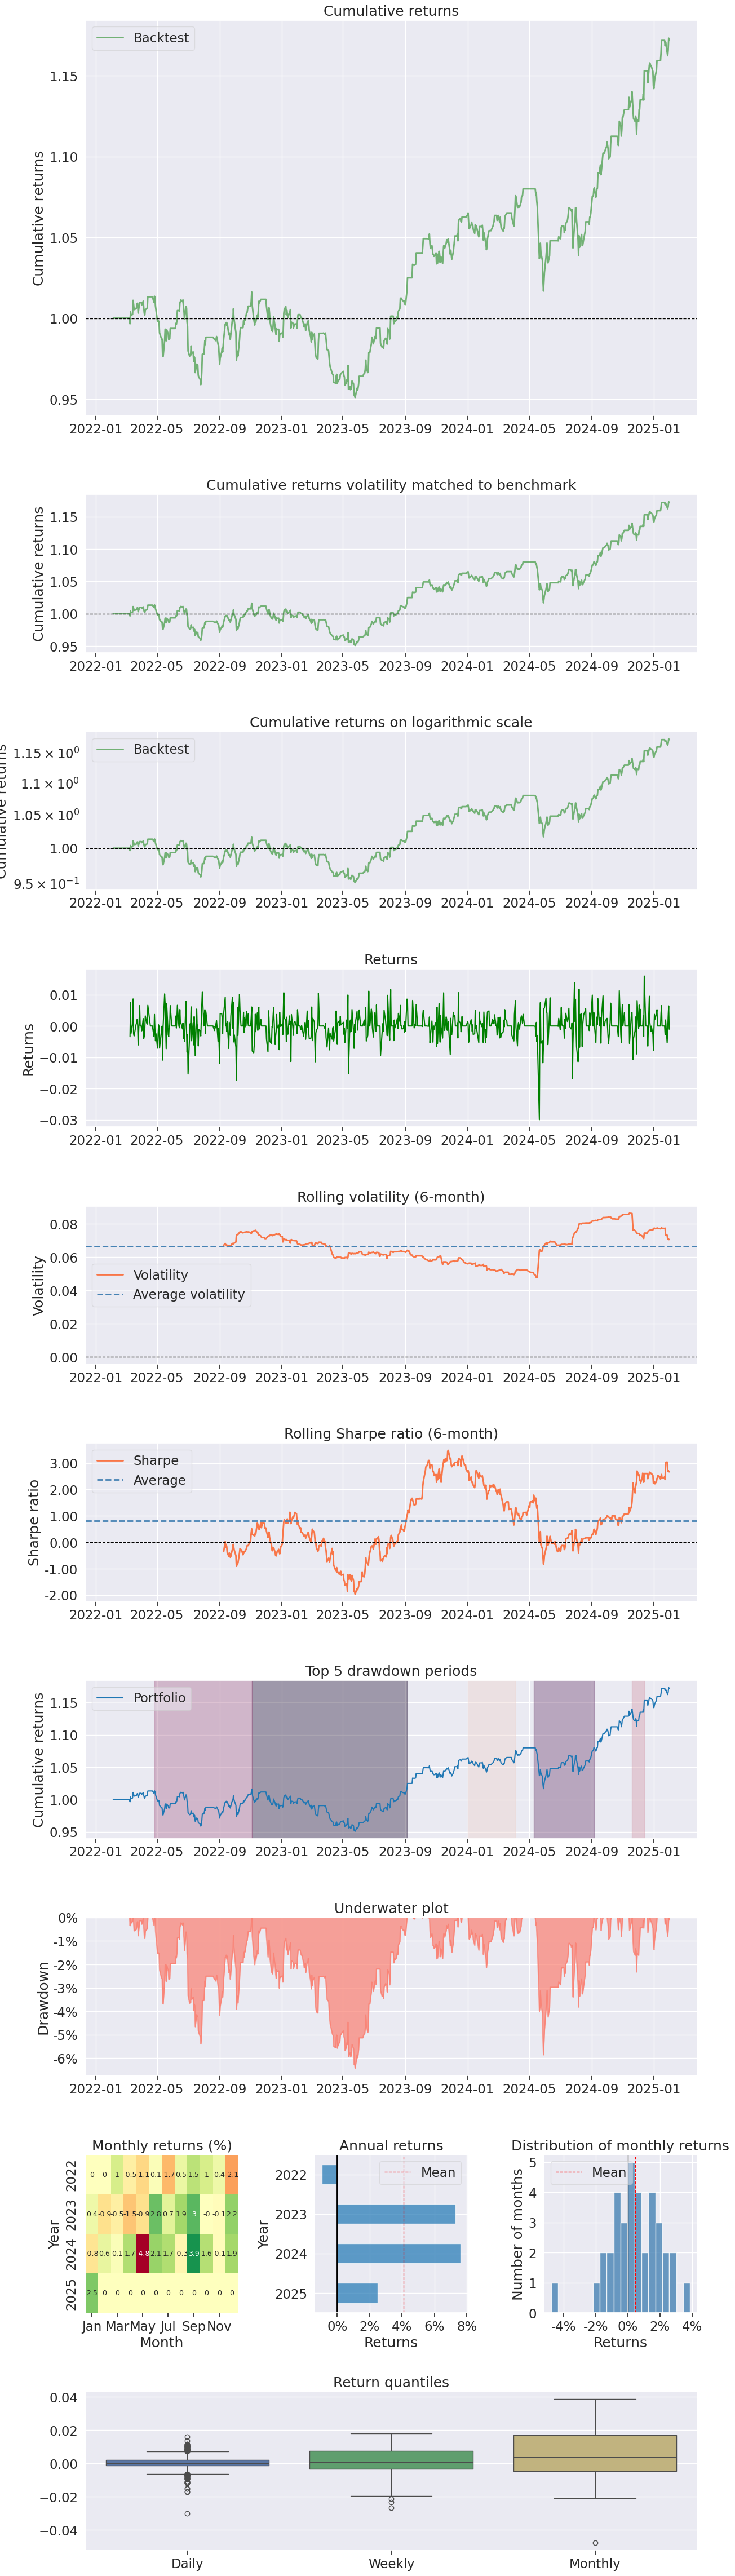

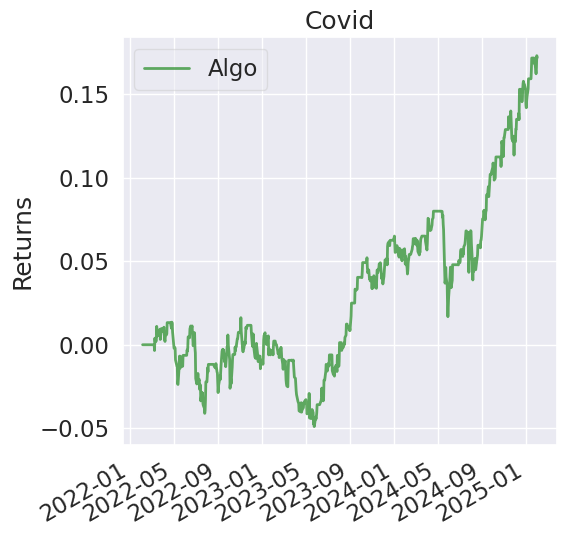

In [93]:
import pyfolio as pf
pf.create_full_tear_sheet(GLDSLV_sliced["strategy_returns"])